Iter 20/100 - Loss: 7.299 | noise: 0.1000 | lengthscale: 0.559
Iter 40/100 - Loss: 4.739 | noise: 0.1000 | lengthscale: 0.477
Iter 60/100 - Loss: 4.050 | noise: 0.1000 | lengthscale: 0.422
Iter 80/100 - Loss: 3.765 | noise: 0.1000 | lengthscale: 0.407
Iter 100/100 - Loss: 3.607 | noise: 0.1000 | lengthscale: 0.391


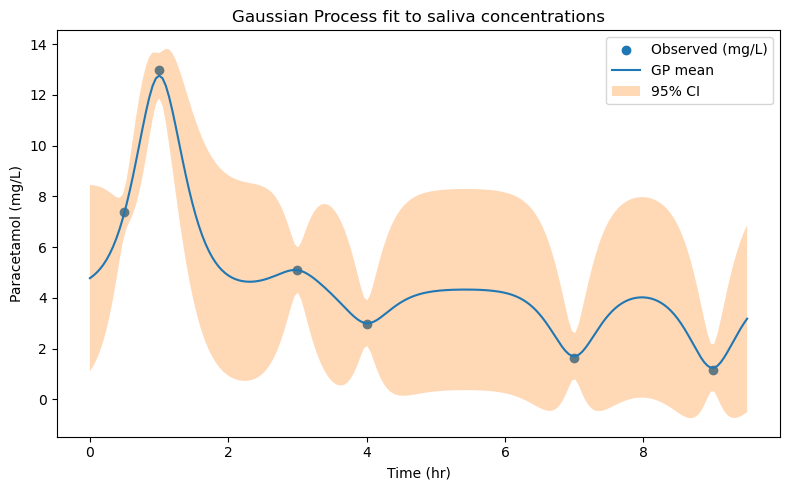

In [15]:
import json
import torch
import gpytorch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# ---------------------------
# 1) Load & flatten JSON
# ---------------------------
with open("subject2.json") as f:
    data = json.load(f)

records = []
for row in data["array"]:
    for entry in row:
        records.append({
            "time_hr": float(entry["time"]),
            "conc_g_per_L": float(entry["value"]),
            "subject": entry["individual"]["name"],
            "dose": entry["interventions"][0]["name"],
            "tissue": entry["tissue"]["name"],
        })

df = pd.DataFrame(records).sort_values("time_hr").reset_index(drop=True)

# Optional: rescale to mg/L for better conditioning (values ~ 1–20 instead of ~0.001–0.01)
df["conc_mg_per_L"] = df["conc_g_per_L"] * 1000.0

# ---------------------------------
# 2) Prepare tensors for GPyTorch
# ---------------------------------
# Train inputs must be shape [N, 1]
x_train = torch.tensor(df["time_hr"].values, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(df["conc_mg_per_L"].values, dtype=torch.float32)

# ---------------------------------
# 3) Define an Exact GP model
# ---------------------------------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # RBF kernel with outputscale (amplitude) learned; add small jitter through default settings
        self.covar_module = gpytorch.kernels.ScaleKernel(
            # gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(0.1, 0.2))
            # gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(0.1, 0.5))
            gpytorch.kernels.MaternKernel(nu=2.5)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ---------------------------------
# 4) Initialize likelihood & model
# ---------------------------------
torch.manual_seed(18)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Fix noise to very small value for interpolation (or use FixedNoiseGaussianLikelihood)
likelihood.noise = 1e-1
likelihood.noise_covar.raw_noise.requires_grad = False  # Fix noise during training
model = ExactGPModel(x_train, y_train, likelihood)

# ---------------------------------
# 5) Train the GP
# ---------------------------------
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    if (i + 1) % 20 == 0:
        print(f"Iter {i+1}/100 - Loss: {loss.item():.3f} | "
              f"noise: {likelihood.noise.item():.4f} | "
              f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f}")

# ---------------------------------
# 6) Predict on a dense grid
# ---------------------------------
model.eval()
likelihood.eval()

x_min, x_max = float(df["time_hr"].min()), float(df["time_hr"].max())
pad = 0.5
x_test = torch.linspace(max(0.0, x_min - pad), x_max + pad, 200).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x_test))

mean = pred.mean
lower, upper = pred.confidence_region()

# ---------------------------------
# 7) Plot (in mg/L)
# ---------------------------------
plt.figure(figsize=(8,5))
plt.scatter(df["time_hr"], df["conc_mg_per_L"], label="Observed (mg/L)")
plt.plot(x_test.squeeze().numpy(), mean.numpy(), label="GP mean")
plt.fill_between(
    x_test.squeeze().numpy(),
    lower.numpy(),
    upper.numpy(),
    alpha=0.3,
    label="95% CI"
)
plt.xlabel("Time (hr)")
plt.ylabel("Paracetamol (mg/L)")
plt.title("Gaussian Process fit to saliva concentrations")
plt.legend()
plt.tight_layout()
plt.show()


Iter 50/250 - Loss: 2.373 | noise: 0.1000 | ℓ: 0.996 | A: 28.089, ka: 0.980, ke: 0.650
Iter 100/250 - Loss: 2.246 | noise: 0.1000 | ℓ: 0.999 | A: 33.674, ka: 0.824, ke: 0.770
Iter 150/250 - Loss: 2.205 | noise: 0.1000 | ℓ: 0.999 | A: 34.714, ka: 0.799, ke: 0.790
Iter 200/250 - Loss: 2.183 | noise: 0.1000 | ℓ: 0.999 | A: 34.892, ka: 0.796, ke: 0.791
Iter 250/250 - Loss: 2.170 | noise: 0.1000 | ℓ: 0.999 | A: 34.939, ka: 0.795, ke: 0.791


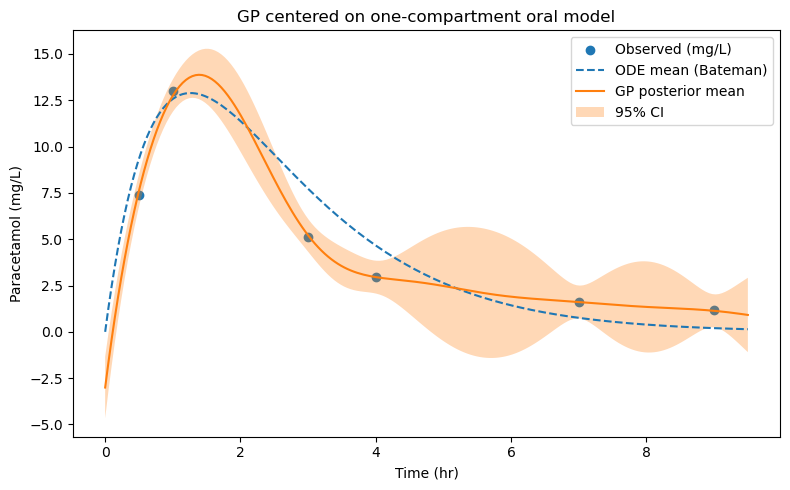

In [9]:
import json
import torch
import gpytorch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# ---------------------------
# 1) Load & flatten JSON
# ---------------------------
with open("subject2.json") as f:
    data = json.load(f)

records = []
for row in data["array"]:
    for entry in row:
        records.append({
            "time_hr": float(entry["time"]),
            "conc_g_per_L": float(entry["value"]),
            "subject": entry["individual"]["name"],
            "dose": entry["interventions"][0]["name"],
            "tissue": entry["tissue"]["name"],
        })

df = pd.DataFrame(records).sort_values("time_hr").reset_index(drop=True)

# Rescale to mg/L (helps conditioning)
df["conc_mg_per_L"] = df["conc_g_per_L"] * 1000.0

# ---------------------------------
# 2) Prepare tensors for GPyTorch
# ---------------------------------
x_train = torch.tensor(df["time_hr"].values, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(df["conc_mg_per_L"].values, dtype=torch.float32)

# ---------------------------------
# 3) Define an ODE-centered mean and GP model
# ---------------------------------
class OneCompOralMean(gpytorch.means.Mean):
    """
    Bateman function mean:
      mu(t) = A * [ka/(ka - ke)] * (exp(-ke t) - exp(-ka t))
    A absorbs F * Dose / V. ka, ke > 0 are learned.
    """
    def __init__(self, initial_A=10.0, initial_ka=1.0, initial_ke=0.2):
        super().__init__()
        # Work in log-space to keep params positive
        self.log_A  = torch.nn.Parameter(torch.log(torch.tensor(initial_A)))
        self.log_ka = torch.nn.Parameter(torch.log(torch.tensor(initial_ka)))
        self.log_ke = torch.nn.Parameter(torch.log(torch.tensor(initial_ke)))

    def forward(self, x):
        t = x.squeeze(-1)  # [N]
        A  = torch.exp(self.log_A)
        ka = torch.exp(self.log_ka)
        ke = torch.exp(self.log_ke)
        # Avoid ka ~= ke numerical issue
        denom = (ka - ke).clamp(min=1e-6)
        bateman = (ka / denom) * (torch.exp(-ke * t) - torch.exp(-ka * t))
        return bateman * A

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # ODE-centered mean
        self.mean_module = OneCompOralMean(
            initial_A=max(y_train.max().item(), 1.0),  # rough scale
            initial_ka=1.0,  # hr^-1 (fast-ish absorption guess)
            initial_ke=0.2,  # hr^-1 (elimination guess)
        )
        # Smooth residuals around ODE with RBF
        self.covar_module = gpytorch.kernels.ScaleKernel(
            # gpytorch.kernels.RBFKernel()
            gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(1, 2))
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ---------------------------------
# 4) Initialize likelihood & model
# ---------------------------------
torch.manual_seed(18)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ExactGPModel(x_train, y_train, likelihood)
# Fix noise to very small value for interpolation (or use FixedNoiseGaussianLikelihood)
likelihood.noise = 1e-1
likelihood.noise_covar.raw_noise.requires_grad = False  # Fix noise during training
# (Optional) put weak priors to keep params reasonable
model.covar_module.base_kernel.lengthscale = 1.0
model.covar_module.outputscale = 1.0
 

# ---------------------------------
# 5) Train the GP
# ---------------------------------
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters(), 'lr': 0.05},
], lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(250):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    if (i + 1) % 50 == 0:
        ka = torch.exp(model.mean_module.log_ka).item()
        ke = torch.exp(model.mean_module.log_ke).item()
        A  = torch.exp(model.mean_module.log_A).item()
        print(f"Iter {i+1}/250 - Loss: {loss.item():.3f} | "
              f"noise: {likelihood.noise.item():.4f} | "
              f"ℓ: {model.covar_module.base_kernel.lengthscale.item():.3f} | "
              f"A: {A:.3f}, ka: {ka:.3f}, ke: {ke:.3f}")

# ---------------------------------
# 6) Predict on a dense grid
# ---------------------------------
model.eval()
likelihood.eval()

x_min, x_max = float(df["time_hr"].min()), float(df["time_hr"].max())
pad = 0.5
x_test = torch.linspace(max(0.0, x_min - pad), x_max + pad, 200).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x_test))

mean = pred.mean
lower, upper = pred.confidence_region()

# Also plot the *parametric mean* alone (without kernel)
with torch.no_grad():
    ode_mean_only = model.mean_module(x_test).detach()

# ---------------------------------
# 7) Plot (in mg/L)
# ---------------------------------
plt.figure(figsize=(8,5))
plt.scatter(df["time_hr"], df["conc_mg_per_L"], label="Observed (mg/L)")
plt.plot(x_test.squeeze().numpy(), ode_mean_only.numpy(), linestyle="--", label="ODE mean (Bateman)")
plt.plot(x_test.squeeze().numpy(), mean.numpy(), label="GP posterior mean")
plt.fill_between(
    x_test.squeeze().numpy(),
    lower.numpy(),
    upper.numpy(),
    alpha=0.3,
    label="95% CI"
)
plt.xlabel("Time (hr)")
plt.ylabel("Paracetamol (mg/L)")
plt.title("GP centered on one-compartment oral model")
plt.legend()
plt.tight_layout()
plt.show()
